In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import os, os.path 
import numpy as np
import pickle
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n'

###### Dataset Description
Each sequence follows the trajectory of the main agent for 11 seconds, while keeping track of all other traffic agents including cars and pedestrians. Agents follow very complex trajectories, such as changing lanes, navigating intersections, and turning.

In [2]:
ROOT_PATH = "../argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs).astype(np.float32)
    
    outputs = None

    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs).astype(np.float32)

    # one hot city information and/or position by bins
    # parmater: Number of bins

    return inputs, outputs

In [3]:
def heatmapDistribution(x, y=None, xLim=None, yLim=None, bins=150, cmap='hot'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    heatmap, xedges, yedges = np.histogram2d(x[:, :, 0].flatten(), x[:, :, 1].flatten(), bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    axs[0].imshow(heatmap.T, extent=extent, interpolation='bilinear', origin='lower', cmap=cmap)

    if y is not None:
        heatmap, xedges, yedges = np.histogram2d(y[:, :, 0].flatten(), y[:, :, 1].flatten(), bins=bins)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        axs[1].imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)

    for ax in axs:
        if xLim:
            ax.set_xlim([xLim[0], xLim[1]])
        if yLim:
            ax.set_ylim([yLim[0], yLim[1]])
    plt.show()

In [4]:
def get_limited_data(rangeX, rangeY, data):
    # get data within a certain range
    inX = np.logical_and(np.any(data[:, :, 0] >= rangeX[0], axis=-1), np.any(data[:, :, 0] <= rangeX[1], axis=-1))
    inY = np.logical_and(np.any(data[:, :, 1] >= rangeY[0], axis=-1), np.any(data[:, :, 1] <= rangeY[1], axis=-1))
    inRange = np.logical_and(inX, inY)
    return data[inRange]

austin


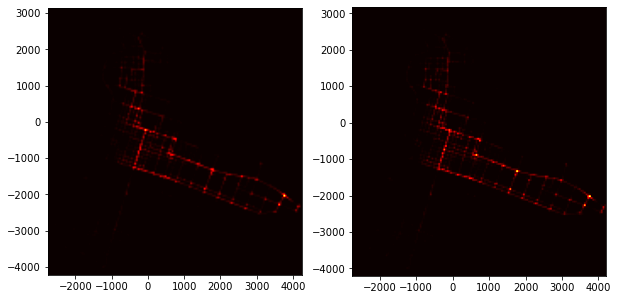

Path Projection centered at 0


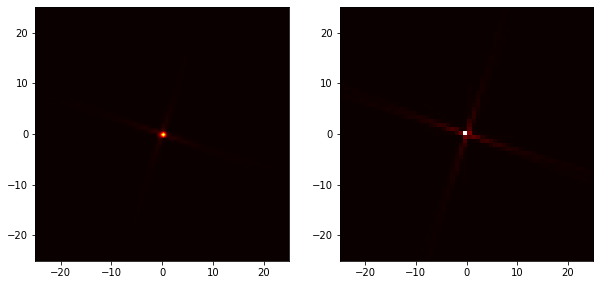

miami


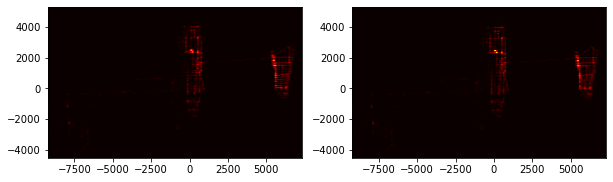

Path Projection centered at 0


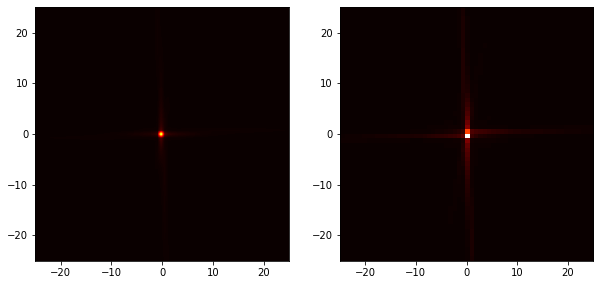

pittsburgh


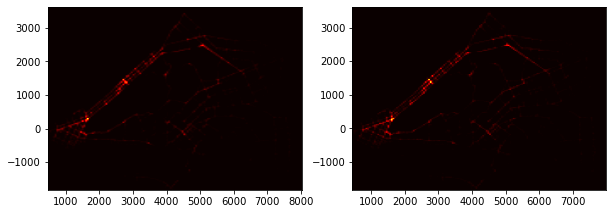

Path Projection centered at 0


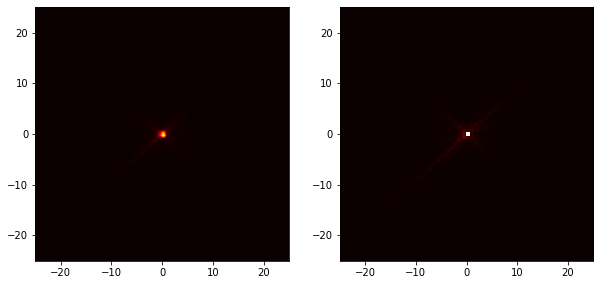

dearborn


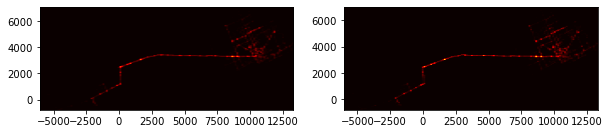

Path Projection centered at 0


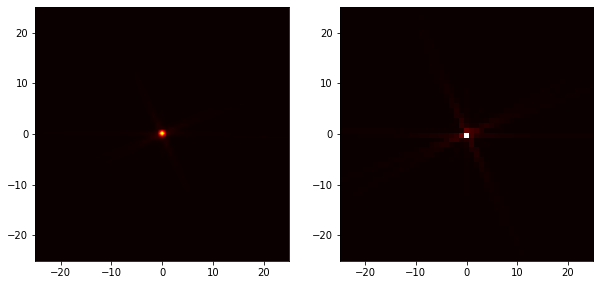

washington-dc


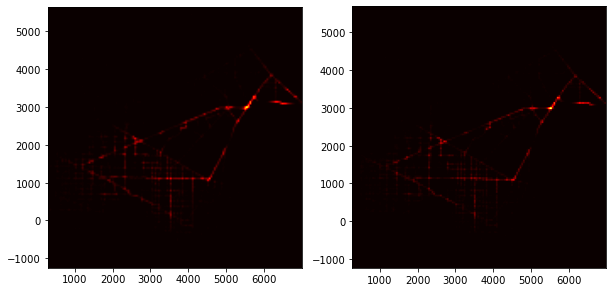

Path Projection centered at 0


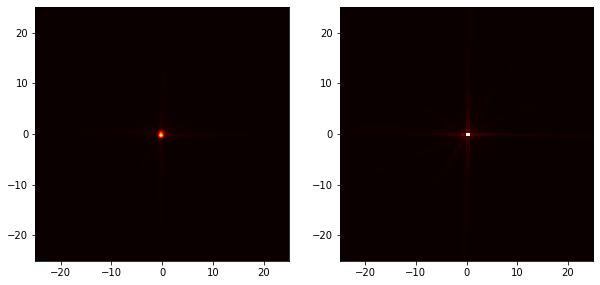

palo-alto


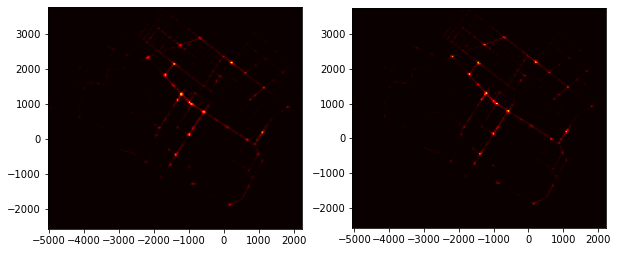

Path Projection centered at 0


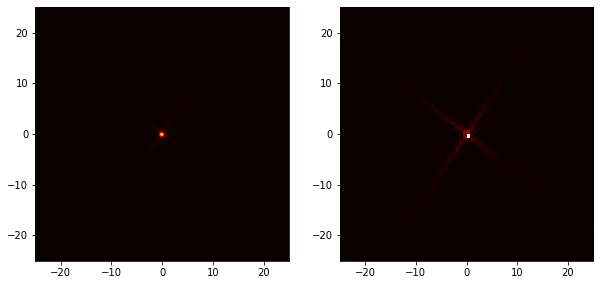

In [5]:
for city in cities:
    print(city)
    x, y  = get_city_trajectories(city)
    heatmapDistribution(x, y, cmap='hot')

    # center at beginning of path
    x = x - np.expand_dims(x[:, 0, :], 1)
    y = y - np.expand_dims(y[:, 0, :], 1)

    rangeX = (-25, 25)
    rangeY = (-25, 25)
    x_ = get_limited_data(rangeX, rangeY, x)
    y_ = get_limited_data(rangeX, rangeY, y)
    print('Path Projection centered at 0')
    heatmapDistribution(x_, y_, xLim=rangeX, yLim=rangeY, bins=300, cmap='hot')
    plt.show()

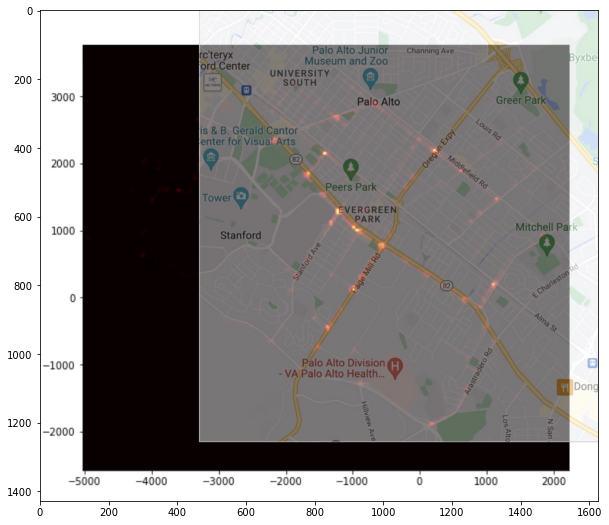

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
img = mpimg.imread('palo-alto-overlay.png')
imgplot = plt.imshow(img)
plt.show()

## Find units
## Upon layering palo alto map from Google maps, we can see that bright spots (stops/near stops) are near intersections and traffic signals.

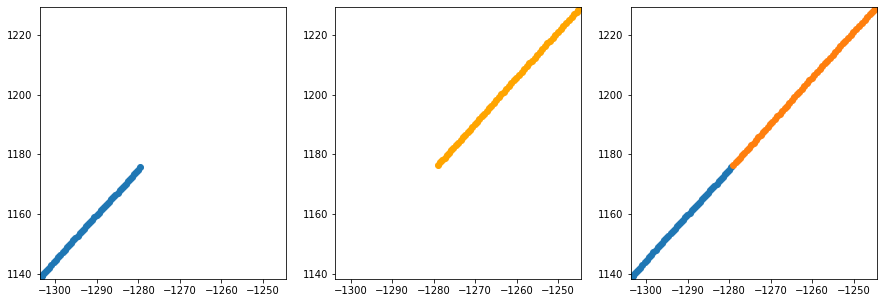

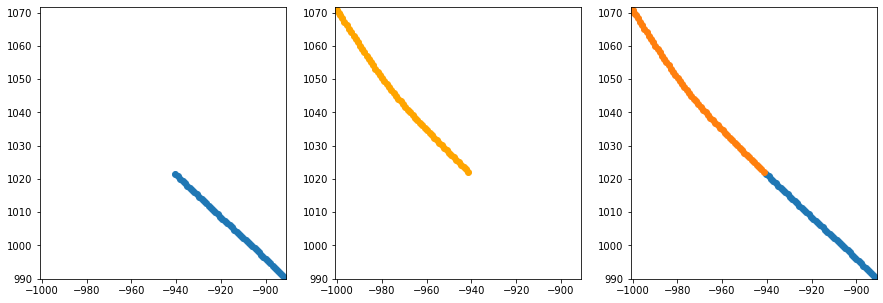

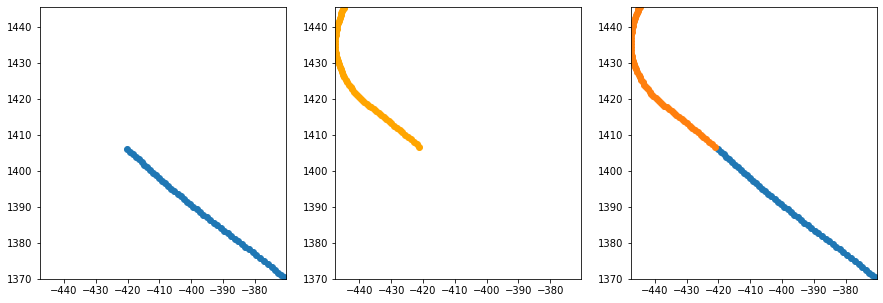

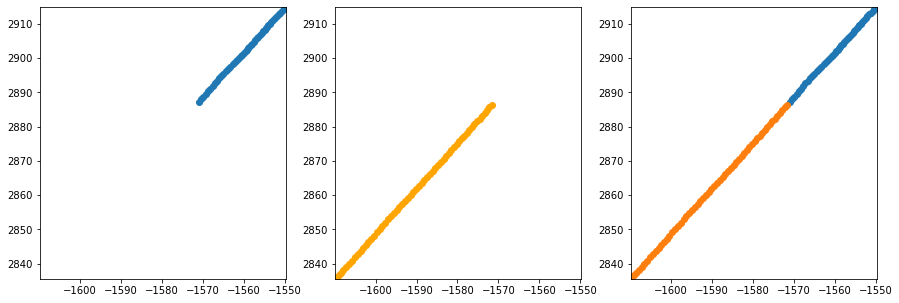

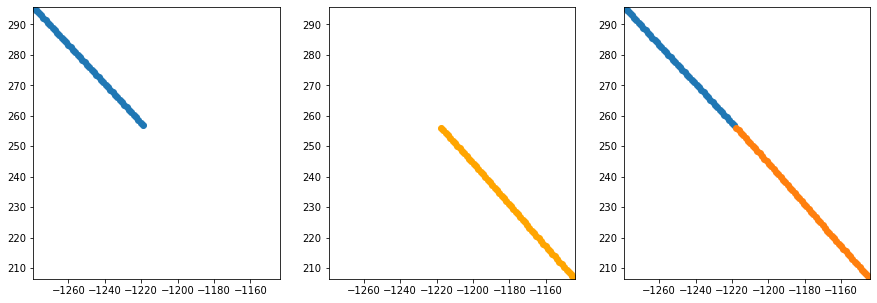

KeyboardInterrupt: 

In [10]:
import time
from IPython.display import clear_output

i = 0

plt.rcParams["figure.figsize"] = [15, 5]

x, y = get_city_trajectories('palo-alto')

while True:
    print("i: " + str(i), end = "\r")
    if i %5 == 0:
        time.sleep(5)
        clear_output(wait=True)
    xMin = min(min(x[i,:,0]), min(y[i, :, 0]))
    xMax = max(max(x[i,:,0]), max(y[i, :, 0]))
    yMin = min(min(x[i,:,1]), min(y[i, :, 1]))
    yMax = max(max(x[i,:,1]), max(y[i, :, 1]))

    ax1 = plt.subplot(1, 3, 1)
    ax1.set_xlim(left=xMin, right=xMax)
    ax1.set_ylim(bottom=yMin, top=yMax)
    ax2 = plt.subplot(1, 3, 2, sharey=ax1, sharex=ax1)
    ax3 = plt.subplot(1, 3, 3, sharey=ax1, sharex=ax1)

    ax1.scatter(x[i,:,0], x[i, :, 1])
    ax2.scatter(y[i,:,0], y[i, :, 1], c='orange')
    ax3.scatter(x[i,:,0], x[i, :, 1])
    ax3.scatter(y[i,:,0], y[i, :, 1])
    i += 1
    plt.show()

# Plot distribution of total distance traveled

In [11]:
def findDists(data):
    dists = []
    for n in range(len(data)):
        dist = 0
        for i in range(data.shape[1] - 1):
            dist += np.linalg.norm(data[n][i+1] - data[n][i])
        dists.append(dist)
    return np.array(dists)

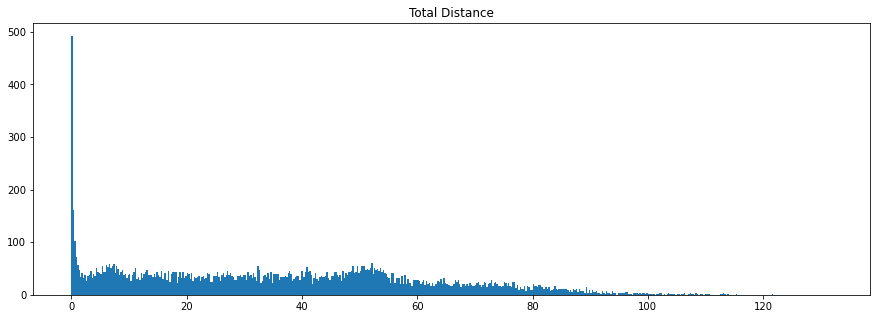

In [38]:
dists = findDists(x)
counts, edges, bars = plt.hist(dists, np.arange(0, max(dists), 0.25))
plt.title('Total Distance')
plt.show()

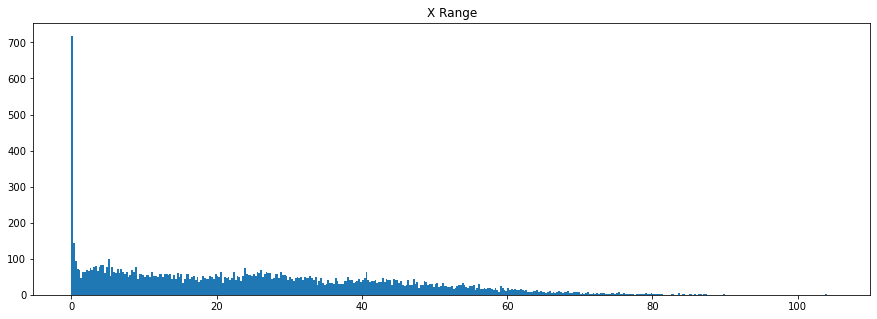

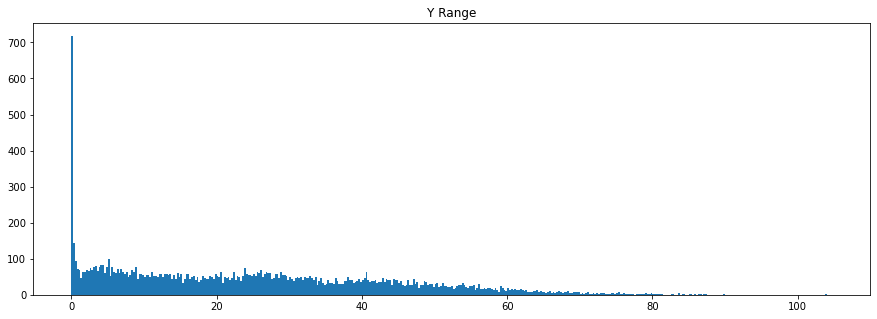

In [37]:
def findRange(data):
    return np.ptp(data, axis=1)

range_ = findRange(x)
range_x = range_[:, 0]
range_y = range_[:, 1]
plt.hist(range_x, np.arange(0, np.max(range_x), 0.25))
plt.title('X Range')
plt.show()
plt.hist(range_x, np.arange(0, np.max(range_x), 0.25))
plt.title('Y Range')
plt.show()


### Projection Clustering

Cluster data points between stops, turns, and straight paths.

Let D, T, L be parameters.

##### Stops: 
 - Sum (distance between points)^2 < D
 - Plot histogram of total distances, 
 - Set D
 - Plot heatmap
 - Print N counts.

In [14]:
# Initially D to the 0.01% percentile.
D = np.quantile(dists, 0.01)
print(D)
idxs = np.where(dists <= D)[0]
len(idxs)

0.037841663239523766


120

In [15]:
# sort index by increasing dists
idxs = np.where(dists <=D)[0]
inc_idxs = np.argsort(dists[idxs])

dists[inc_idxs]

array([4.45465364e+01, 7.58360291e+01, 6.22374293e+01, 5.99460646e+01,
       6.25673571e+01, 7.41320586e+01, 2.61664628e+01, 4.56273234e+01,
       3.49770115e+01, 9.03692391e+01, 1.00345496e+01, 4.52866520e+01,
       5.11486185e+01, 2.37777869e-01, 7.22102389e+01, 1.28746278e+01,
       9.07524313e+01, 4.93031600e+01, 1.28551347e+01, 1.50360778e+00,
       8.13208501e+01, 3.05367257e+01, 4.88484696e+01, 4.45163151e+00,
       4.01201358e+01, 8.50959623e+00, 5.85872068e+01, 3.40720671e+01,
       6.91654420e+01, 1.35279371e+01, 4.56134577e+01, 2.68525815e+01,
       4.49319850e+01, 5.97090455e+01, 3.36098056e+01, 5.13004088e+01,
       6.26866701e+01, 7.86833654e+00, 7.91518064e+00, 8.39984699e+01,
       5.29580057e+01, 4.67641984e+01, 2.89132026e+01, 1.99230124e+00,
       3.44704049e+01, 3.33426722e+01, 5.63454141e+01, 6.29962975e+01,
       9.21433300e+01, 3.17098315e+00, 5.26648954e+01, 8.86862743e-02,
       4.28512307e+01, 6.32378396e+01, 1.76356689e-02, 5.21347857e+01,
      

In [16]:
def plot_path(point):
    f, ax = plt.subplots(figsize=(3,3))
    x, y = point[:, 0], point[:, 1]
    plt.scatter(x, y)

    xMin = min(x)
    xMax = max(x)
    yMin = min(y)
    yMax = max(y)

    ax.set_xlim(left=xMin, right=xMax)
    ax.set_ylim(bottom=yMin, top=yMax)
    ax.ticklabel_format(useOffset=False)
    plt.show()

Input Projection


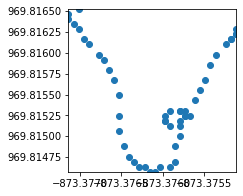

Output Projection


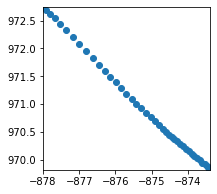

0.005428330725408159
Input Projection


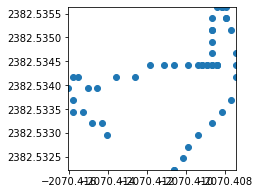

Output Projection


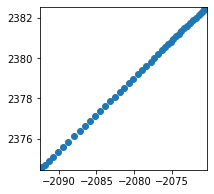

0.01763566888985224
Input Projection


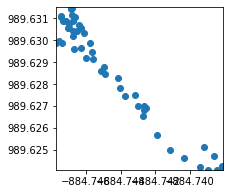

Output Projection


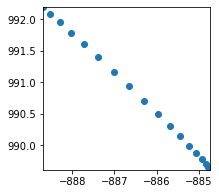

0.028754001192282885
Input Projection


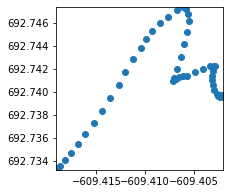

Output Projection


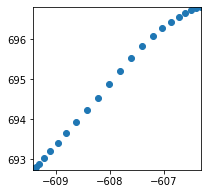

0.034590129616844933
Input Projection


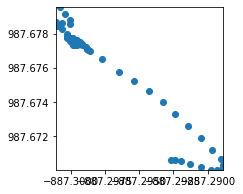

Output Projection


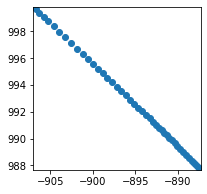

0.0253671838217997
Input Projection


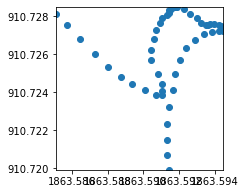

Output Projection


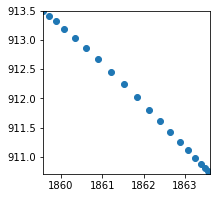

0.02495389040268492
Input Projection


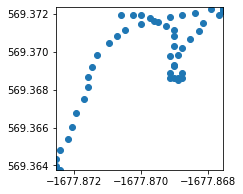

Output Projection


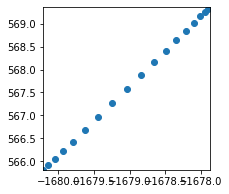

0.020234602838172577
Input Projection


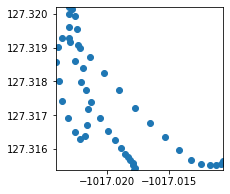

Output Projection


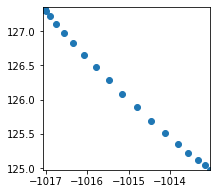

0.030257018974225502
Input Projection


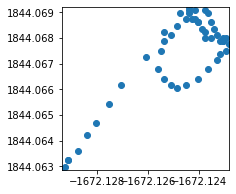

Output Projection


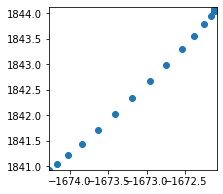

0.019910256669390947
Input Projection


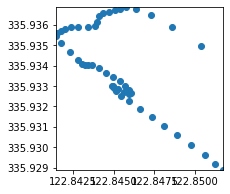

Output Projection


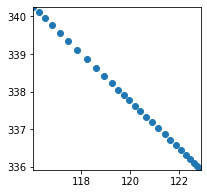

0.024553466399083845
Input Projection


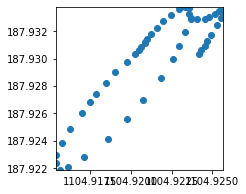

Output Projection


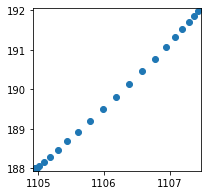

0.03540454216999933
Input Projection


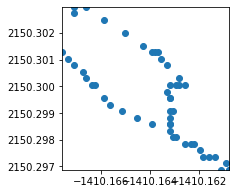

Output Projection


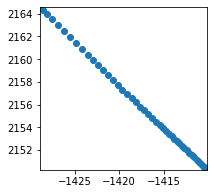

0.019844057911541313
Input Projection


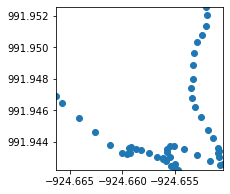

Output Projection


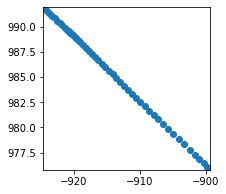

0.032113332839799114
Input Projection


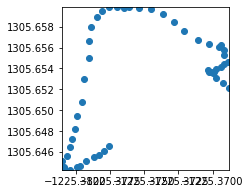

Output Projection


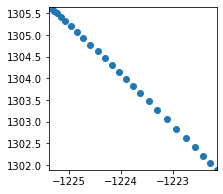

0.036139268064289354
Input Projection


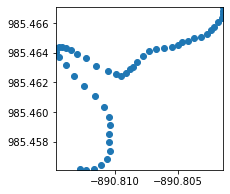

Output Projection


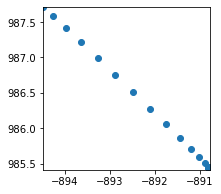

0.027198353316634893
Input Projection


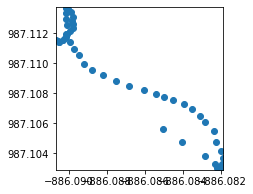

Output Projection


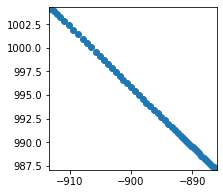

0.022285351289610844
Input Projection


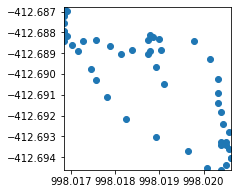

Output Projection


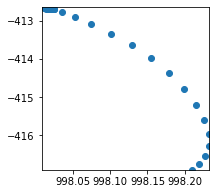

0.02355806770356139
Input Projection


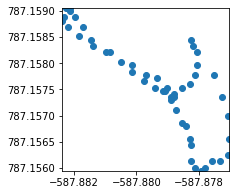

Output Projection


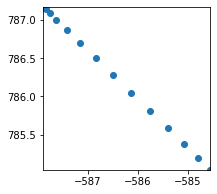

0.014220037373888772
Input Projection


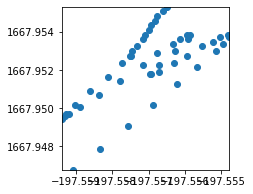

Output Projection


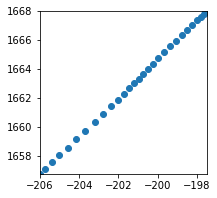

0.025985068699810654
Input Projection


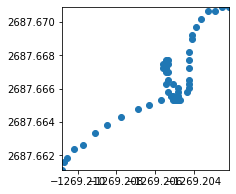

Output Projection


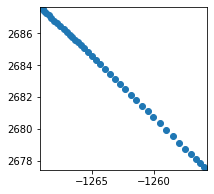

0.02086500174482353
Input Projection


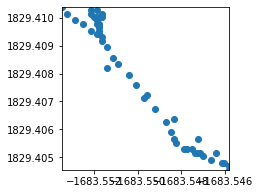

Output Projection


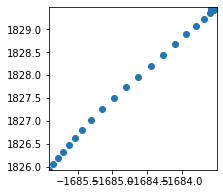

0.019358944875421003
Input Projection


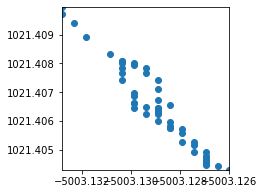

Output Projection


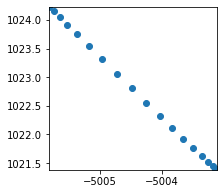

0.02315039304085076
Input Projection


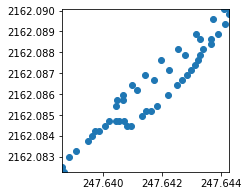

Output Projection


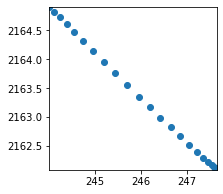

0.021110609028255567
Input Projection


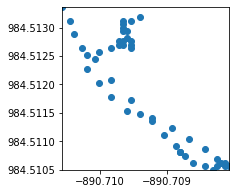

Output Projection


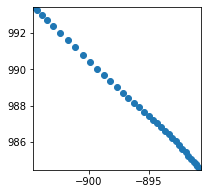

0.008760891658312175
Input Projection


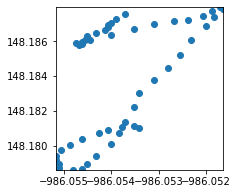

Output Projection


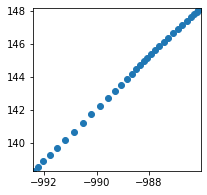

0.01973005572654074
Input Projection


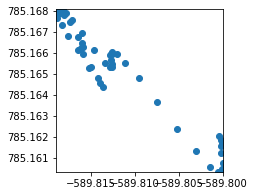

Output Projection


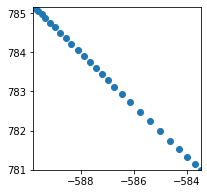

0.036375426658196375
Input Projection


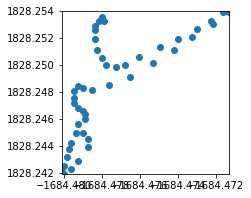

Output Projection


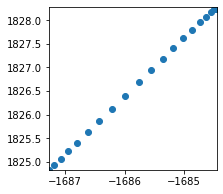

0.03403519852145109
Input Projection


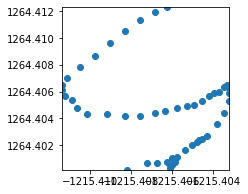

Output Projection


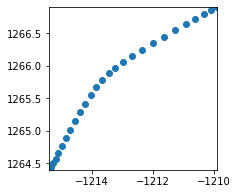

0.028519831379526295
Input Projection


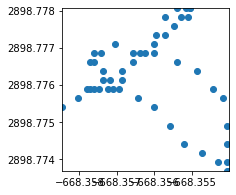

Output Projection


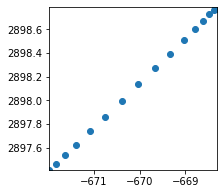

0.01949203442200087
Input Projection


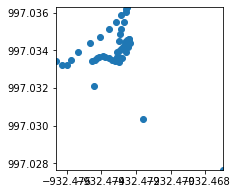

Output Projection


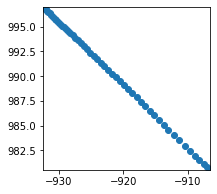

0.023991842914256267
Input Projection


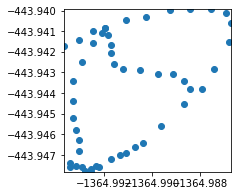

Output Projection


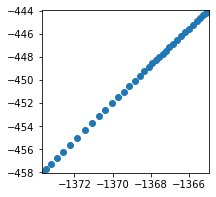

0.031063472823007032
Input Projection


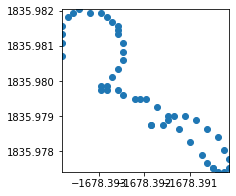

Output Projection


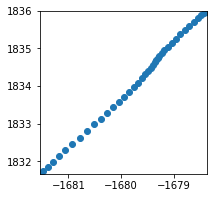

0.011256063080509193
Input Projection


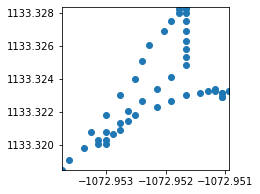

Output Projection


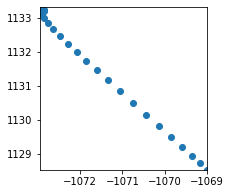

0.023642124462639913
Input Projection


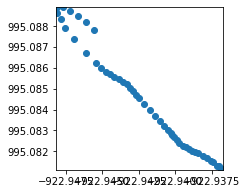

Output Projection


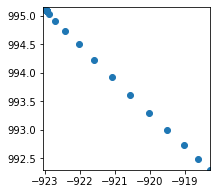

0.017952100177353714
Input Projection


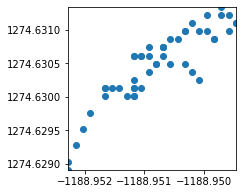

Output Projection


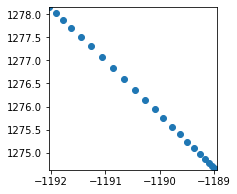

0.007873546492191963
Input Projection


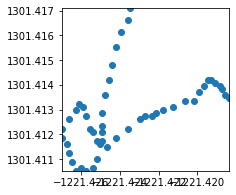

Output Projection


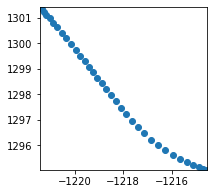

0.020620193652575836
Input Projection


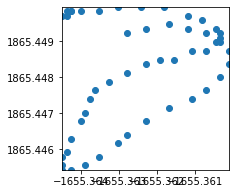

Output Projection


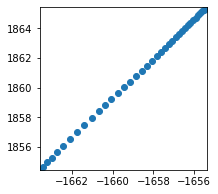

0.019455917325103655
Input Projection


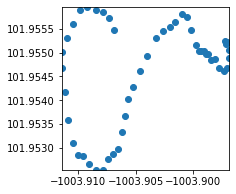

Output Projection


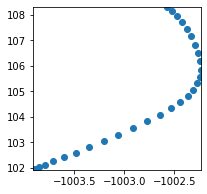

0.02271873528661672
Input Projection


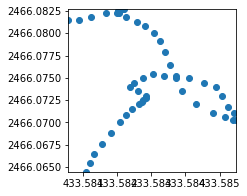

Output Projection


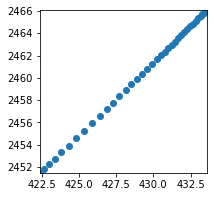

0.03311711046262644
Input Projection


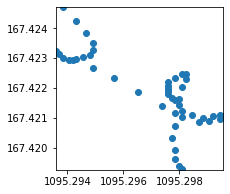

Output Projection


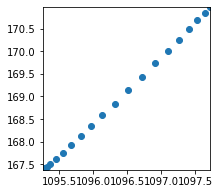

0.01674795788130723
Input Projection


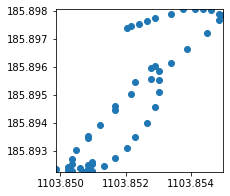

Output Projection


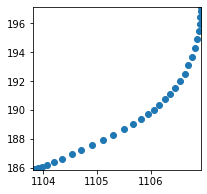

0.0214011104835663
Input Projection


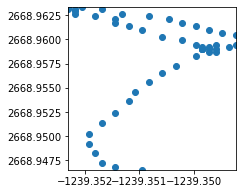

Output Projection


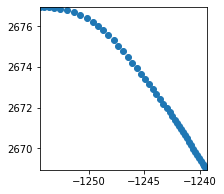

0.02547232373035513
Input Projection


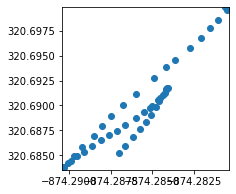

Output Projection


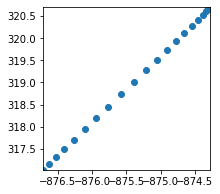

0.03706030795001425
Input Projection


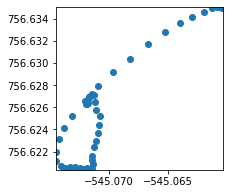

Output Projection


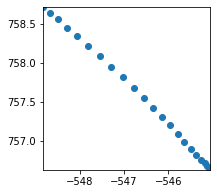

0.03266151645220816
Input Projection


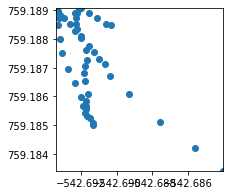

Output Projection


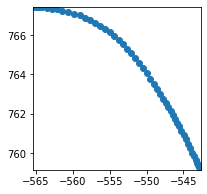

0.02249219956866
Input Projection


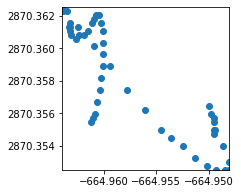

Output Projection


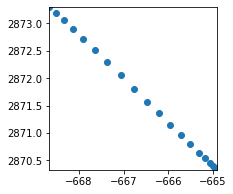

0.03615740925306454
Input Projection


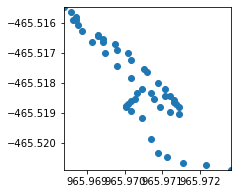

Output Projection


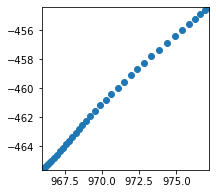

0.01735763204487739
Input Projection


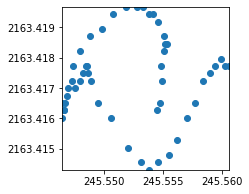

Output Projection


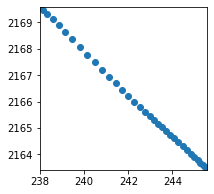

0.031166987697361037
Input Projection


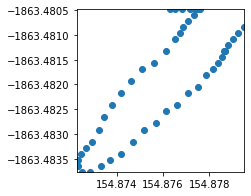

Output Projection


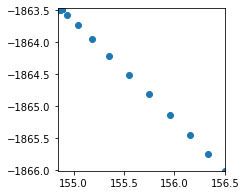

0.015509819131693803
Input Projection


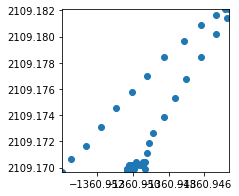

Output Projection


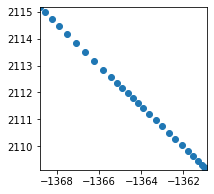

0.033742804429493845
Input Projection


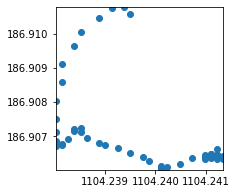

Output Projection


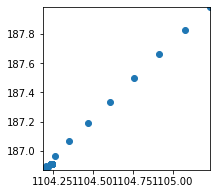

0.010234497502096929
Input Projection


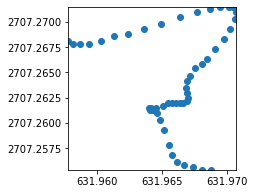

Output Projection


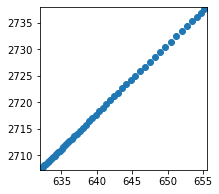

0.03578091668896377
Input Projection


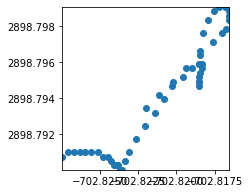

Output Projection


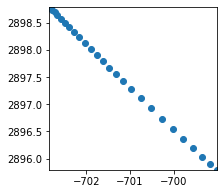

0.027126197004690766
Input Projection


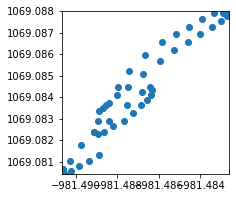

Output Projection


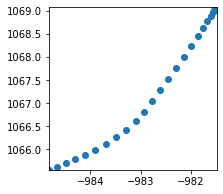

0.028502155488240533
Input Projection


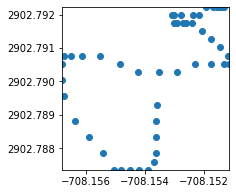

Output Projection


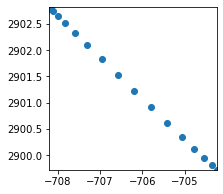

0.017950752953765914
Input Projection


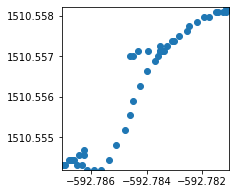

Output Projection


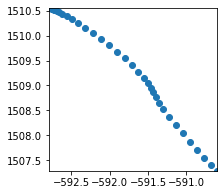

0.012868815698311664
Input Projection


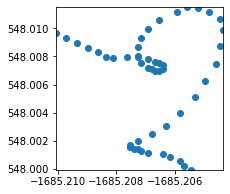

Output Projection


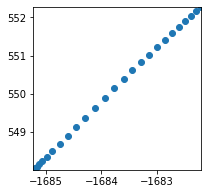

0.02469695186300669
Input Projection


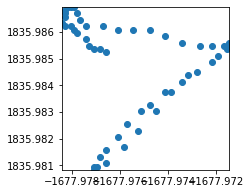

Output Projection


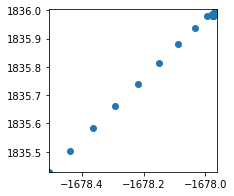

0.022105797062977217
Input Projection


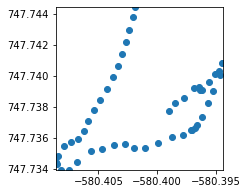

Output Projection


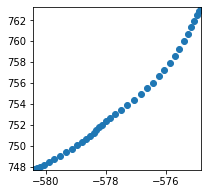

0.03598568915913347
Input Projection


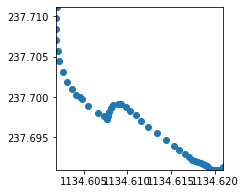

Output Projection


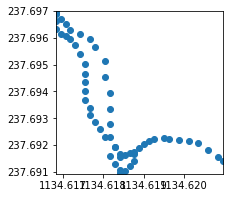

0.0336145300680073
Input Projection


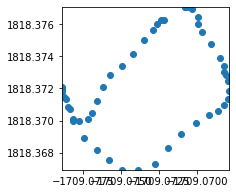

Output Projection


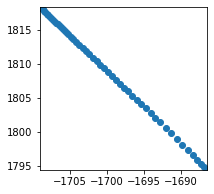

0.03329111781204119
Input Projection


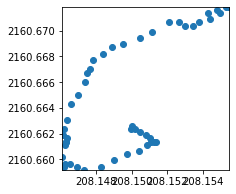

Output Projection


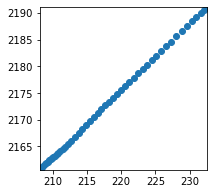

0.027273603074718267
Input Projection


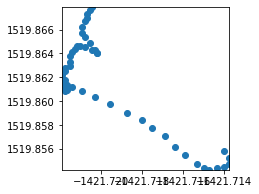

Output Projection


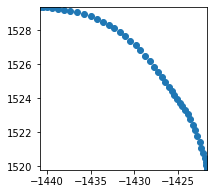

0.022666110904538073
Input Projection


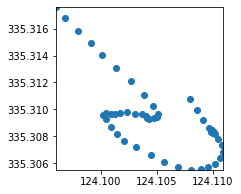

Output Projection


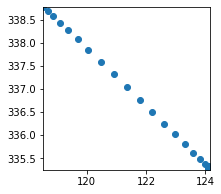

0.03558090365550015
Input Projection


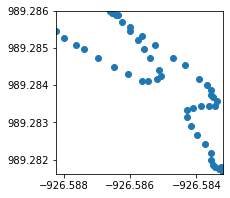

Output Projection


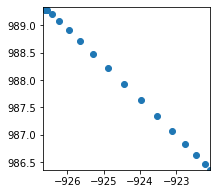

0.013653309935762081
Input Projection


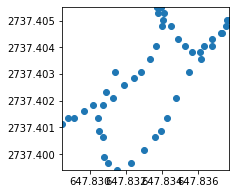

Output Projection


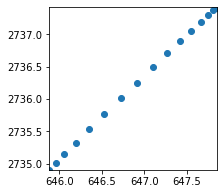

0.026219680294161662
Input Projection


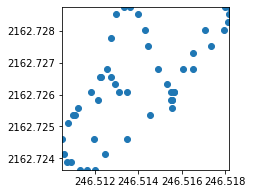

Output Projection


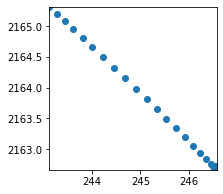

0.02867534221149981
Input Projection


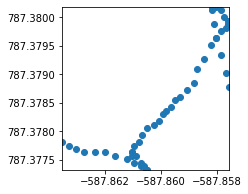

Output Projection


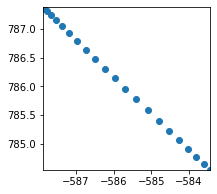

0.010240985175187234
Input Projection


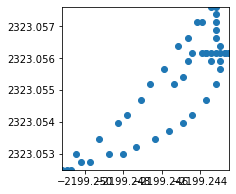

Output Projection


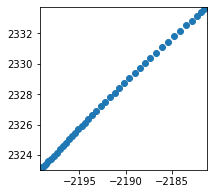

0.02541530877351761
Input Projection


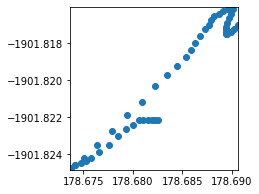

Output Projection


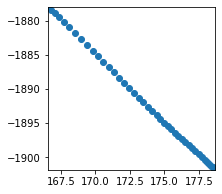

0.031152880750596523
Input Projection


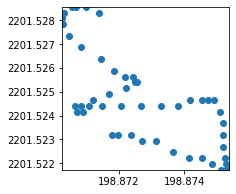

Output Projection


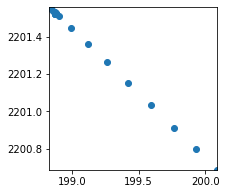

0.019158158043865114
Input Projection


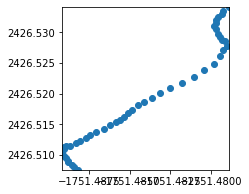

Output Projection


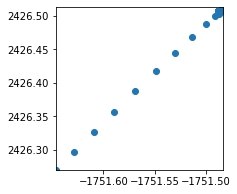

0.030346506740897894
Input Projection


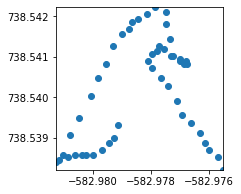

Output Projection


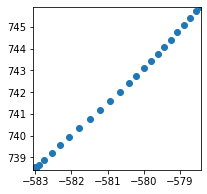

0.01529437525459798
Input Projection


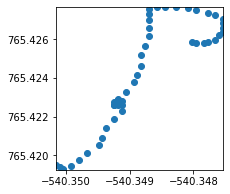

Output Projection


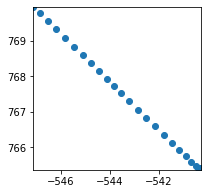

0.012426079141732771
Input Projection


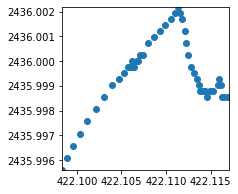

Output Projection


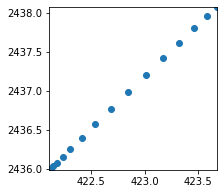

0.023833660583477467
Input Projection


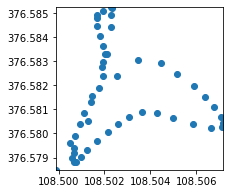

Output Projection


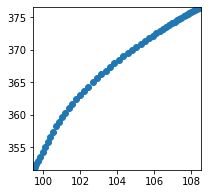

0.03157474932959303
Input Projection


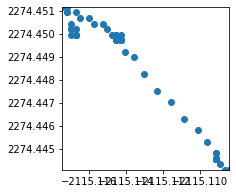

Output Projection


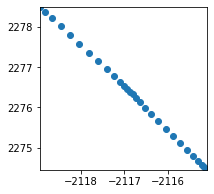

0.01484437394537963
Input Projection


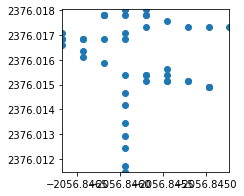

Output Projection


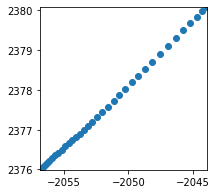

0.013434688706183806
Input Projection


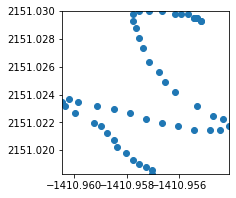

Output Projection


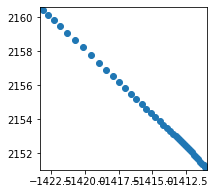

0.025787961087189615
Input Projection


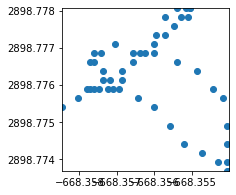

Output Projection


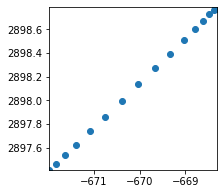

0.01949203442200087
Input Projection


KeyboardInterrupt: 

In [17]:
for i in range(len(idxs)):
    print("Input Projection")
    plot_path(x[idxs[i]])
    print("Output Projection")
    plot_path(y[idxs[i]])
    print(dists[idxs[i]])

In [ ]:
print(idxs)
np.all(x[idxs[0]] == x[idxs[1]]), np.all(y[idxs[0]] == y[idxs[1]])

### Plotting the 2 paths with the lowest total distance traveled, we found a duplicate in the dataset. 
### Further data exploration and cleaning is needed.

In [ ]:
# Plot last 5 points to look closer at the noise.
last_ = x[idxs][0][-5:]
plt.scatter(last_[:, 0], last_[:, 1])

### Additionally from the plotted path, we can see that the path that looks like a stop actually has some noise (e-3) that is impossible to derive from actual driving cars.
### Furthermore, the last data point of the input does not lign up with the output path.
### To overcome this, we might have to use previous positional embedding in our models.

### Let's take a closer look at the stops.

In [ ]:
# Plot 0.1 percentile
D = np.quantile(dists, 0.05)
sorted_idxs = np.argsort(dists)
idxs = np.where(dists[sorted_idxs] <= D)[0]
len(idxs)

In [ ]:
heatmapDistribution(x[sorted_idxs][idxs])

In [ ]:
# From the percentile, plot last 5 to determine the cutoff value
for i in idxs[-5:]:
    print("Input Projection")
    plot_path(x[sorted_idxs][idxs[i]])
    plot_path(y[sorted_idxs][idxs[i]])

##### Turns:
Fit quadratic formula ax^2 + bx + c, where a > T

Set random T, then plot histogram of As, plot extremes and random samples, and print N counts.

##### Straights:

Slope = (EndY - StartY) / (EndX - StartX)
sum(slope * startX - Yi)^2 < L
 - Set random L
 - 1) plot histogram of distances (End - Start)^2
 - 2) plot histogram of direction/slope, then convert histogram to Polar
 - 3) plot heatmap of End, centered at 0,0.

In [ ]:
# trajectory clustering
from sklearn.cluster import  KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(x)